In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

In [60]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [68]:
# Selecting training_set from begining of 2015 till end of 2017, we can do this because our index in date object
# and selecting test_set from begining of 2018 onwards
training_data = dataset['2015':'2017'].sort_values(by=['ticker','date'])
test_data = dataset['2018':].sort_values(by=['ticker','date'])

In [69]:
# It is kind of data preprocessing in order to obtain more accurancy of our model
# Once I trained our model without transform training set I got higher loss
sc = MinMaxScaler(feature_range=(0,1))

In [70]:
# Preparing training_set for all stocks
training_set = training_data[['adj_close']].values

In [76]:
# Selecting a particular stock ('A') for test_set
test_set = test_data.loc[test_data['ticker'] == 'A'][['adj_close']].values

In [79]:
sc.partial_fit(training_set)
sc.partial_fit(test_set)
training_set_scaled = sc.transform(training_set)
test_set_scaled = sc.transform(test_set)

In [86]:
# Count entries of each stock
tickers_entry = training_data.groupby(['ticker'])['adj_close'].count()
tickers_entry

ticker
A       755
AA      754
AABA    755
AAL     755
AAME    696
AAN     755
AAOI    755
AAON    755
AAP     755
AAPL    755
AAT     755
AAV     755
AAWW    755
AAXJ    755
AAXN    755
AB      755
ABAC    743
ABAX    755
ABB     755
ABBV    755
ABC     755
ABCB    755
ABCD    755
ABDC    755
ABEO    755
ABEV    755
ABG     755
ABIL    663
ABIO    755
ABM     755
       ... 
ZAGG    755
ZAYO    755
ZBH     755
ZBIO    637
ZBK     717
ZBRA    755
ZEAL    100
ZEN     755
ZEUS    755
ZF      755
ZFGN    755
ZG      755
ZGNX    755
ZION    755
ZIOP    755
ZIV     754
ZIXI    755
ZKIN     83
ZLAB     71
ZN      755
ZNGA    755
ZNH     753
ZOES    755
ZSAN    657
ZTO     296
ZTR     755
ZTS     755
ZUMZ    755
ZYME    171
ZYNE    607
Name: adj_close, Length: 5493, dtype: int64

In [87]:
# Define x_train y_train which timesteps is 60
timesteps = 60
x_train = []
y_train = []
s = 0
for entries in tickers_entry:
    j = 0
    for i in range(timesteps, entries):
        x_train.append(training_set_scaled[s+j:s+i,0])
        y_train.append(training_set_scaled[s+i,0])
        j += 1
    s += entries

In [88]:
# Convert into numpy array
X_train, Y_train = np.array(x_train), np.array(y_train)

In [89]:
X_train.shape, Y_train.shape

((3362879, 60), (3362879,))

In [90]:
# Reshaping X_train to match with our GRU network input
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [91]:
X_train.shape

(3362879, 60, 1)

In [92]:
# Callback function `earlystopping` to trigger while training it monitor 'loss'
# start from first epoch it record min value of loss and if model can not find 
# lower loss value in next 3 epochs model will stop training.
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, mode='min')

In [93]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value

regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set

In [94]:
# Training model with earlystopping callbacks function
# It's processing 6000 sample a step66
regressorGRU.fit(X_train,Y_train,epochs=30,batch_size=6000, callbacks=[es], validation_split=0.3)

Train on 2354015 samples, validate on 1008864 samples
Epoch 1/30
2354015/2354015 [==============================] - 250s 106us/step - loss: 1.7860e-07 - val_loss: 6.2141e-06
Epoch 2/30
2354015/2354015 [==============================] - 246s 105us/step - loss: 1.7861e-07 - val_loss: 6.2145e-06
Epoch 3/30
2354015/2354015 [==============================] - 245s 104us/step - loss: 1.7819e-07 - val_loss: 6.2142e-06
Epoch 4/30
2354015/2354015 [==============================] - 245s 104us/step - loss: 1.7916e-07 - val_loss: 6.2144e-06


In [129]:
# Save model
regressorGRU.save('gru_adj_close_price_prediction_v1.h5')

# Helper function #

In [95]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The mean squared error is {}.".format(mse))

In [96]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {}'.format(ticker))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predicting on Test set #

In [136]:
# Define X_test , Y_test
Y_test = test_set[60:]
x_test = []
for i in range(timesteps, len(test_set_scaled)):
    x_test.append(test_set_scaled[i-timesteps:i, 0])
X_test = np.array(x_test)

In [137]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [138]:
# Predicting result
predicted_result = regressorGRU.predict(X_test)

In [139]:
y_pred = sc.inverse_transform(predicted_result)

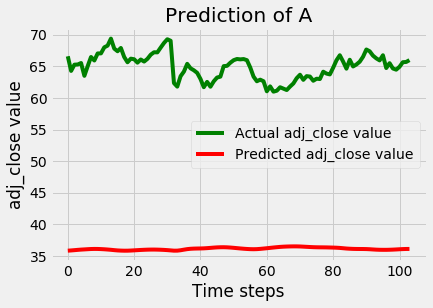

In [140]:
# Plotting graph
plotting_graph(Y_test, y_pred, 'A')

## Calculate MSE on test set ##

In [141]:
# Evaluating our model
return_mse(Y_test,y_pred)

The mean squared error is 834.9886063454258.


# Predicting on training_set #

In [202]:
A_adj_close = training_data.loc[training_data['ticker'] == 'A'][['adj_close']].values

In [203]:
A_adj_close_scaled = sc.transform(A_adj_close)

In [204]:
Y = A_adj_close[60:]
x = []
for i in range(timesteps, len(A_adj_close_scaled)):
    x.append(A_adj_close_scaled[i-timesteps:i,0])

In [205]:
X = np.array(x)

In [206]:
X.shape

(695, 60)

In [207]:
X = np.reshape(X, (X.shape[0],X.shape[1],1))

In [208]:
predicted_result = regressorGRU.predict(X)
y_pred_train = sc.inverse_transform(predicted_result)

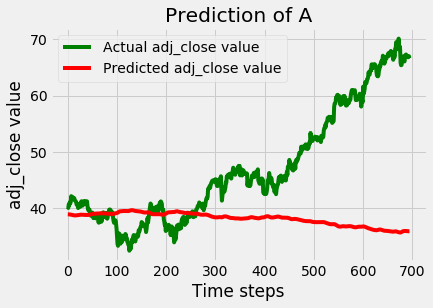

In [210]:
plotting_graph(Y, y_pred_train, 'A')

## Calculate MSE on training_set ##

In [211]:
# Evaluating our model
return_mse(Y,y_pred_train)

The mean squared error is 206.34467891142523.
